## seaborn

In [1]:
import anndata as ad
import numpy as np

In [3]:
import sys
import os

# Define the path to the main folder
main_folder = "/Users/apple/Desktop/KB/SCSeq_LineageBarcoding2/SCSeq_LineageBarcoding/SCLineage_ConstrativeLearning/main_semi"

# Add it to sys.path
sys.path.append(main_folder)

import LCL_eval

In [4]:
input_dir = "/Users/apple/Desktop/KB/data"

train_semi = np.load(input_dir+'/feat_LCL_2025/Larry_top200/feat_0417_Larry_top200_semi/scBaseEncoderFeat_Z_bs150_tau0.5.npy')
test_semi = np.load(input_dir+'/feat_LCL_2025/Larry_top200/feat_0417_Larry_top200_semi/test_embedding.npy')

train_semi_10 = np.load(input_dir+'/feat_LCL_2025/Larry_top200/feat_0417_Larry_top200_semi_10/scBaseEncoderFeat_Z_bs150_tau0.5.npy')
test_semi_10 = np.load(input_dir+'/feat_LCL_2025/Larry_top200/feat_0417_Larry_top200_semi_10/test_embedding.npy')

adata_train = ad.read_h5ad(input_dir+'/LarryData/train_test/Larry_200_train.h5ad')
adata_test = ad.read_h5ad(input_dir+'/LarryData/train_test/Larry_200_test.h5ad')

### Embedding of dim 10

In [5]:
adata_train.obsm["LCL_embedding_semi"] = train_semi
adata_test.obsm["LCL_embedding_semi"] = test_semi

adata_train.obs["dataset"] = "train"
adata_test.obs["dataset"] = "test"

adata = ad.concat([adata_train, adata_test], axis=0, join='outer')

In [6]:
import umap

reducer = umap.UMAP()

embedding_umap = reducer.fit_transform(adata.obsm["LCL_embedding_semi"])

adata.obsm["X_umap"] = embedding_umap

In [ ]:
import umap

reducer = umap.UMAP()

embedding_umap = reducer.fit_transform(adata.obsm["LCL_embedding_dim10"])

adata.obsm["X_umap"] = embedding_umap

In [7]:
import pandas as pd

# Count number of cells per lineage
clone_counts = adata.obs["clone_id"].value_counts()

# Get the top 5 largest lineages
top_5_clones = clone_counts.index[:5]

# Assign 'Other' to all lineages except the top 5
adata.obs["clone_group"] = adata.obs["clone_id"].apply(lambda x: x if x in top_5_clones else "Other")

# Convert to categorical
adata.obs["clone_group"] = adata.obs["clone_group"].astype("category")

# Print for verification
print(adata.obs["clone_group"].value_counts())

clone_group
Other    10627
1261       177
2370       165
5714       141
292        134
5209       129
Name: count, dtype: int64


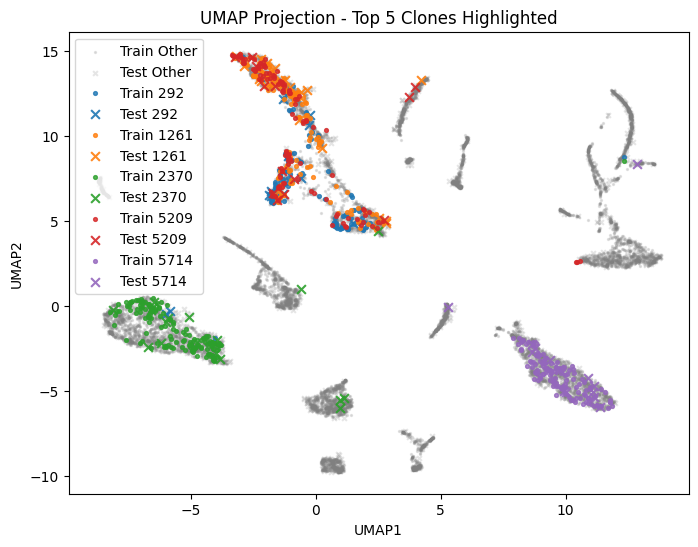

In [8]:
import matplotlib.pyplot as plt
import numpy as np

def plot_umap(adata, colormap="tab10"):
    """
    Plots UMAP with:
    - Top 5 clones in distinct colors (plotted on top)
    - Other clones in gray with lower opacity
    - Train cells as dots, Test cells as crosses
    - Larger marker size for top 5 clones
    """
    umap_coords = adata.obsm["X_umap"]

    # Extract train and test indices
    train_idx = adata.obs["dataset"] == "train"
    test_idx = adata.obs["dataset"] == "test"

    # Get unique clone groups
    unique_clones = adata.obs["clone_group"].cat.categories

    # Define a colormap for the top 5 clones, others in gray
    colors = plt.get_cmap(colormap)(range(len(unique_clones) - 1))  # Leave space for gray
    color_map = dict(zip(unique_clones[:-1], colors))  # Map top 5 clones
    color_map["Other"] = "gray"  # Set 'Other' to gray

    plt.figure(figsize=(8, 6))

    # **Step 1**: Plot "Other" cells first (background with low opacity)
    idx_train_other = (adata.obs["clone_group"] == "Other") & train_idx
    idx_test_other = (adata.obs["clone_group"] == "Other") & test_idx

    plt.scatter(umap_coords[idx_train_other, 0], umap_coords[idx_train_other, 1], 
                color=color_map["Other"], s=8, marker=".", alpha=0.2, label="Train Other")  # Lower opacity

    plt.scatter(umap_coords[idx_test_other, 0], umap_coords[idx_test_other, 1], 
                color=color_map["Other"], s=12, marker="x", alpha=0.2, label="Test Other")  # Lower opacity

    # **Step 2**: Plot top 5 clones on top (larger size)
    for clone in unique_clones[:-1]:  # Skip "Other"
        idx_train = (adata.obs["clone_group"] == clone) & train_idx
        idx_test = (adata.obs["clone_group"] == clone) & test_idx

        # Train: Dots
        plt.scatter(umap_coords[idx_train, 0], umap_coords[idx_train, 1], 
                    color=color_map[clone], s=30, marker=".", alpha=0.8, label=f"Train {clone}")  # Bigger size

        # Test: Crosses
        plt.scatter(umap_coords[idx_test, 0], umap_coords[idx_test, 1], 
                    color=color_map[clone], s=40, marker="x", alpha=0.9, label=f"Test {clone}")  # Bigger size

    plt.xlabel("UMAP1")
    plt.ylabel("UMAP2")
    plt.title("UMAP Projection - Top 5 Clones Highlighted")
    plt.legend()
    plt.show()

# Run the function to plot
plot_umap(adata)

### Train 

In [11]:
import matplotlib.pyplot as plt
import numpy as np

def plot_umap_with_lineages(adata, n_top_lineages=5, colormap="tab10"):
    """
    Plots UMAP from `adata.obsm["X_umap"]` with:
    - Top N clones in distinct colors (plotted on top)
    - Other clones in gray with lower opacity
    - Train cells as dots, Test cells as crosses
    
    Parameters:
    - adata (AnnData): AnnData object with precomputed UMAP in `.obsm["X_umap"]`
    - n_top_lineages (int): Number of largest lineages to highlight in the plot
    - colormap (str): Matplotlib colormap for the distinct top N lineages
    
    Output:
    - A UMAP scatter plot (does NOT modify `adata`)
    """

    ### **1️⃣ Check If Required Fields Exist**
    if "X_umap" not in adata.obsm:
        raise ValueError("UMAP coordinates missing! Ensure `adata.obsm['X_umap']` is computed.")
    
    if "LCL_embedding_semi" not in adata.obsm:
        raise ValueError("Contrastive learning embeddings missing! Ensure `adata.obsm['LCL_embedding_dim10']` exists.")
    
    if "clone_id" not in adata.obs:
        raise ValueError("Clone ID column missing! Ensure `adata.obs['clone_id']` exists.")
    
    if "dataset" not in adata.obs:
        raise ValueError("Dataset column missing! Ensure `adata.obs['dataset']` exists with 'train' and 'test' values.")

    ### **2️⃣ Identify the Top N Largest Lineages**
    print(f"Identifying the top {n_top_lineages} largest lineages...")
    clone_counts = adata.obs["clone_id"].value_counts()
    top_n_clones = clone_counts.index[:n_top_lineages]

    # Assign "Other" to all but the top N lineages
    adata.obs["clone_group"] = adata.obs["clone_id"].apply(lambda x: x if x in top_n_clones else "Other")
    
    # Convert to categorical for easy plotting
    adata.obs["clone_group"] = adata.obs["clone_group"].astype("category")

    ### **3️⃣ Plot UMAP with Custom Formatting**
    print("Plotting UMAP with lineage-specific colors and train/test markers...")

    umap_coords = adata.obsm["X_umap"]
    train_idx = adata.obs["dataset"] == "train"
    test_idx = adata.obs["dataset"] == "test"
    
    unique_clones = adata.obs["clone_group"].cat.categories

    # Define a colormap for the top N clones, others in gray
    colors = plt.get_cmap(colormap)(range(len(unique_clones) - 1))  # Leave space for gray
    color_map = dict(zip(unique_clones[:-1], colors))  # Map top N clones
    color_map["Other"] = "gray"  # Set 'Other' to gray

    plt.figure(figsize=(8, 6))

    # **Step 1**: Plot "Other" cells first (background with low opacity)
    idx_train_other = (adata.obs["clone_group"] == "Other") & train_idx
    idx_test_other = (adata.obs["clone_group"] == "Other") & test_idx

    plt.scatter(umap_coords[idx_train_other, 0], umap_coords[idx_train_other, 1], 
                color=color_map["Other"], s=8, marker=".", alpha=0.2, label="Train Other")

    plt.scatter(umap_coords[idx_test_other, 0], umap_coords[idx_test_other, 1], 
                color=color_map["Other"], s=8, marker="x", alpha=0.2, label="Test Other")

    # **Step 2**: Plot top N clones on top (larger size)
    for clone in unique_clones[:-1]:  # Skip "Other"
        idx_train = (adata.obs["clone_group"] == clone) & train_idx
        idx_test = (adata.obs["clone_group"] == clone) & test_idx

        # Train: Dots
        plt.scatter(umap_coords[idx_train, 0], umap_coords[idx_train, 1], 
                    color=color_map[clone], s=40, marker=".", alpha=0.8, label=f"Train {clone}")

        # Test: Crosses
        plt.scatter(umap_coords[idx_test, 0], umap_coords[idx_test, 1], 
                    color=color_map[clone], s=40, marker="x", alpha=1, label=f"Test {clone}")

    plt.xlabel("UMAP1")
    plt.ylabel("UMAP2")
    plt.title(f"UMAP Projection - Top {n_top_lineages} Clones Highlighted")
    plt.legend()
    plt.show()

Identifying the top 1 largest lineages...
Plotting UMAP with lineage-specific colors and train/test markers...


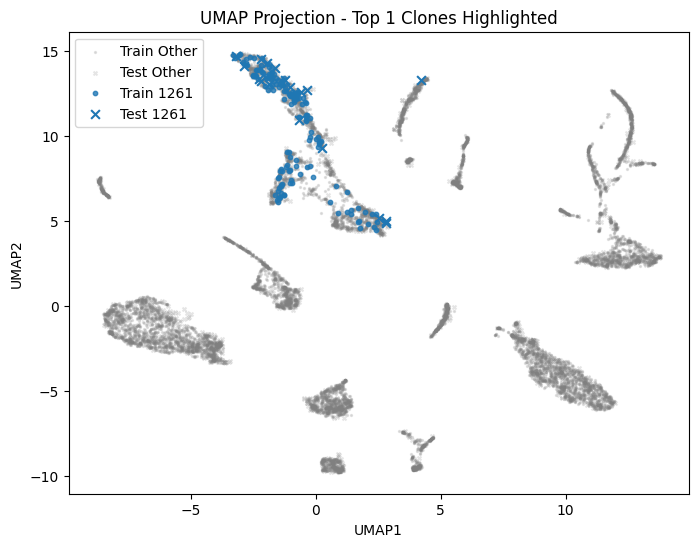

In [12]:
plot_umap_with_lineages(adata, n_top_lineages=1)

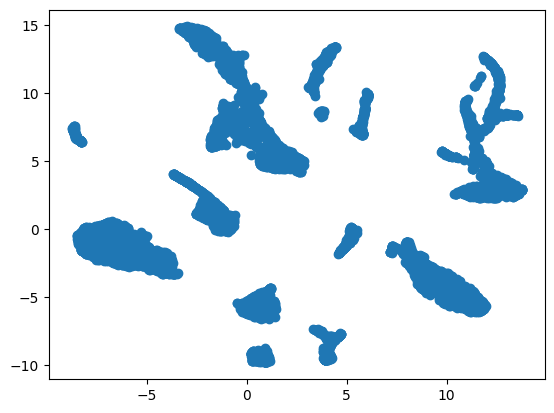

In [13]:
import matplotlib.pyplot as plt
plt.scatter(embedding_umap[:,0],embedding_umap[:,1])

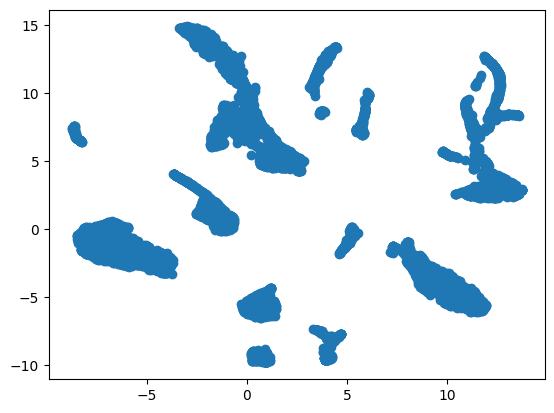

In [14]:
plt.scatter(embedding_umap[:10147,0],embedding_umap[:10147,1])

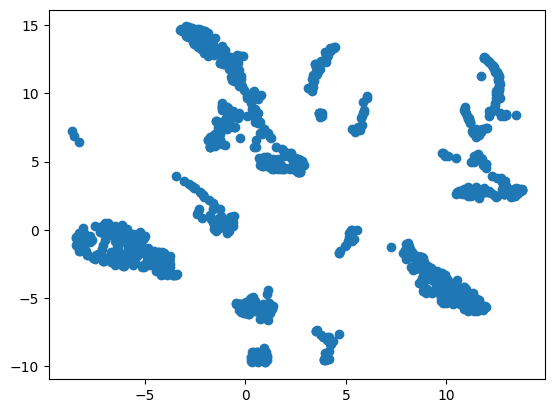

In [15]:
plt.scatter(embedding_umap[10148:,0],embedding_umap[10148:,1])

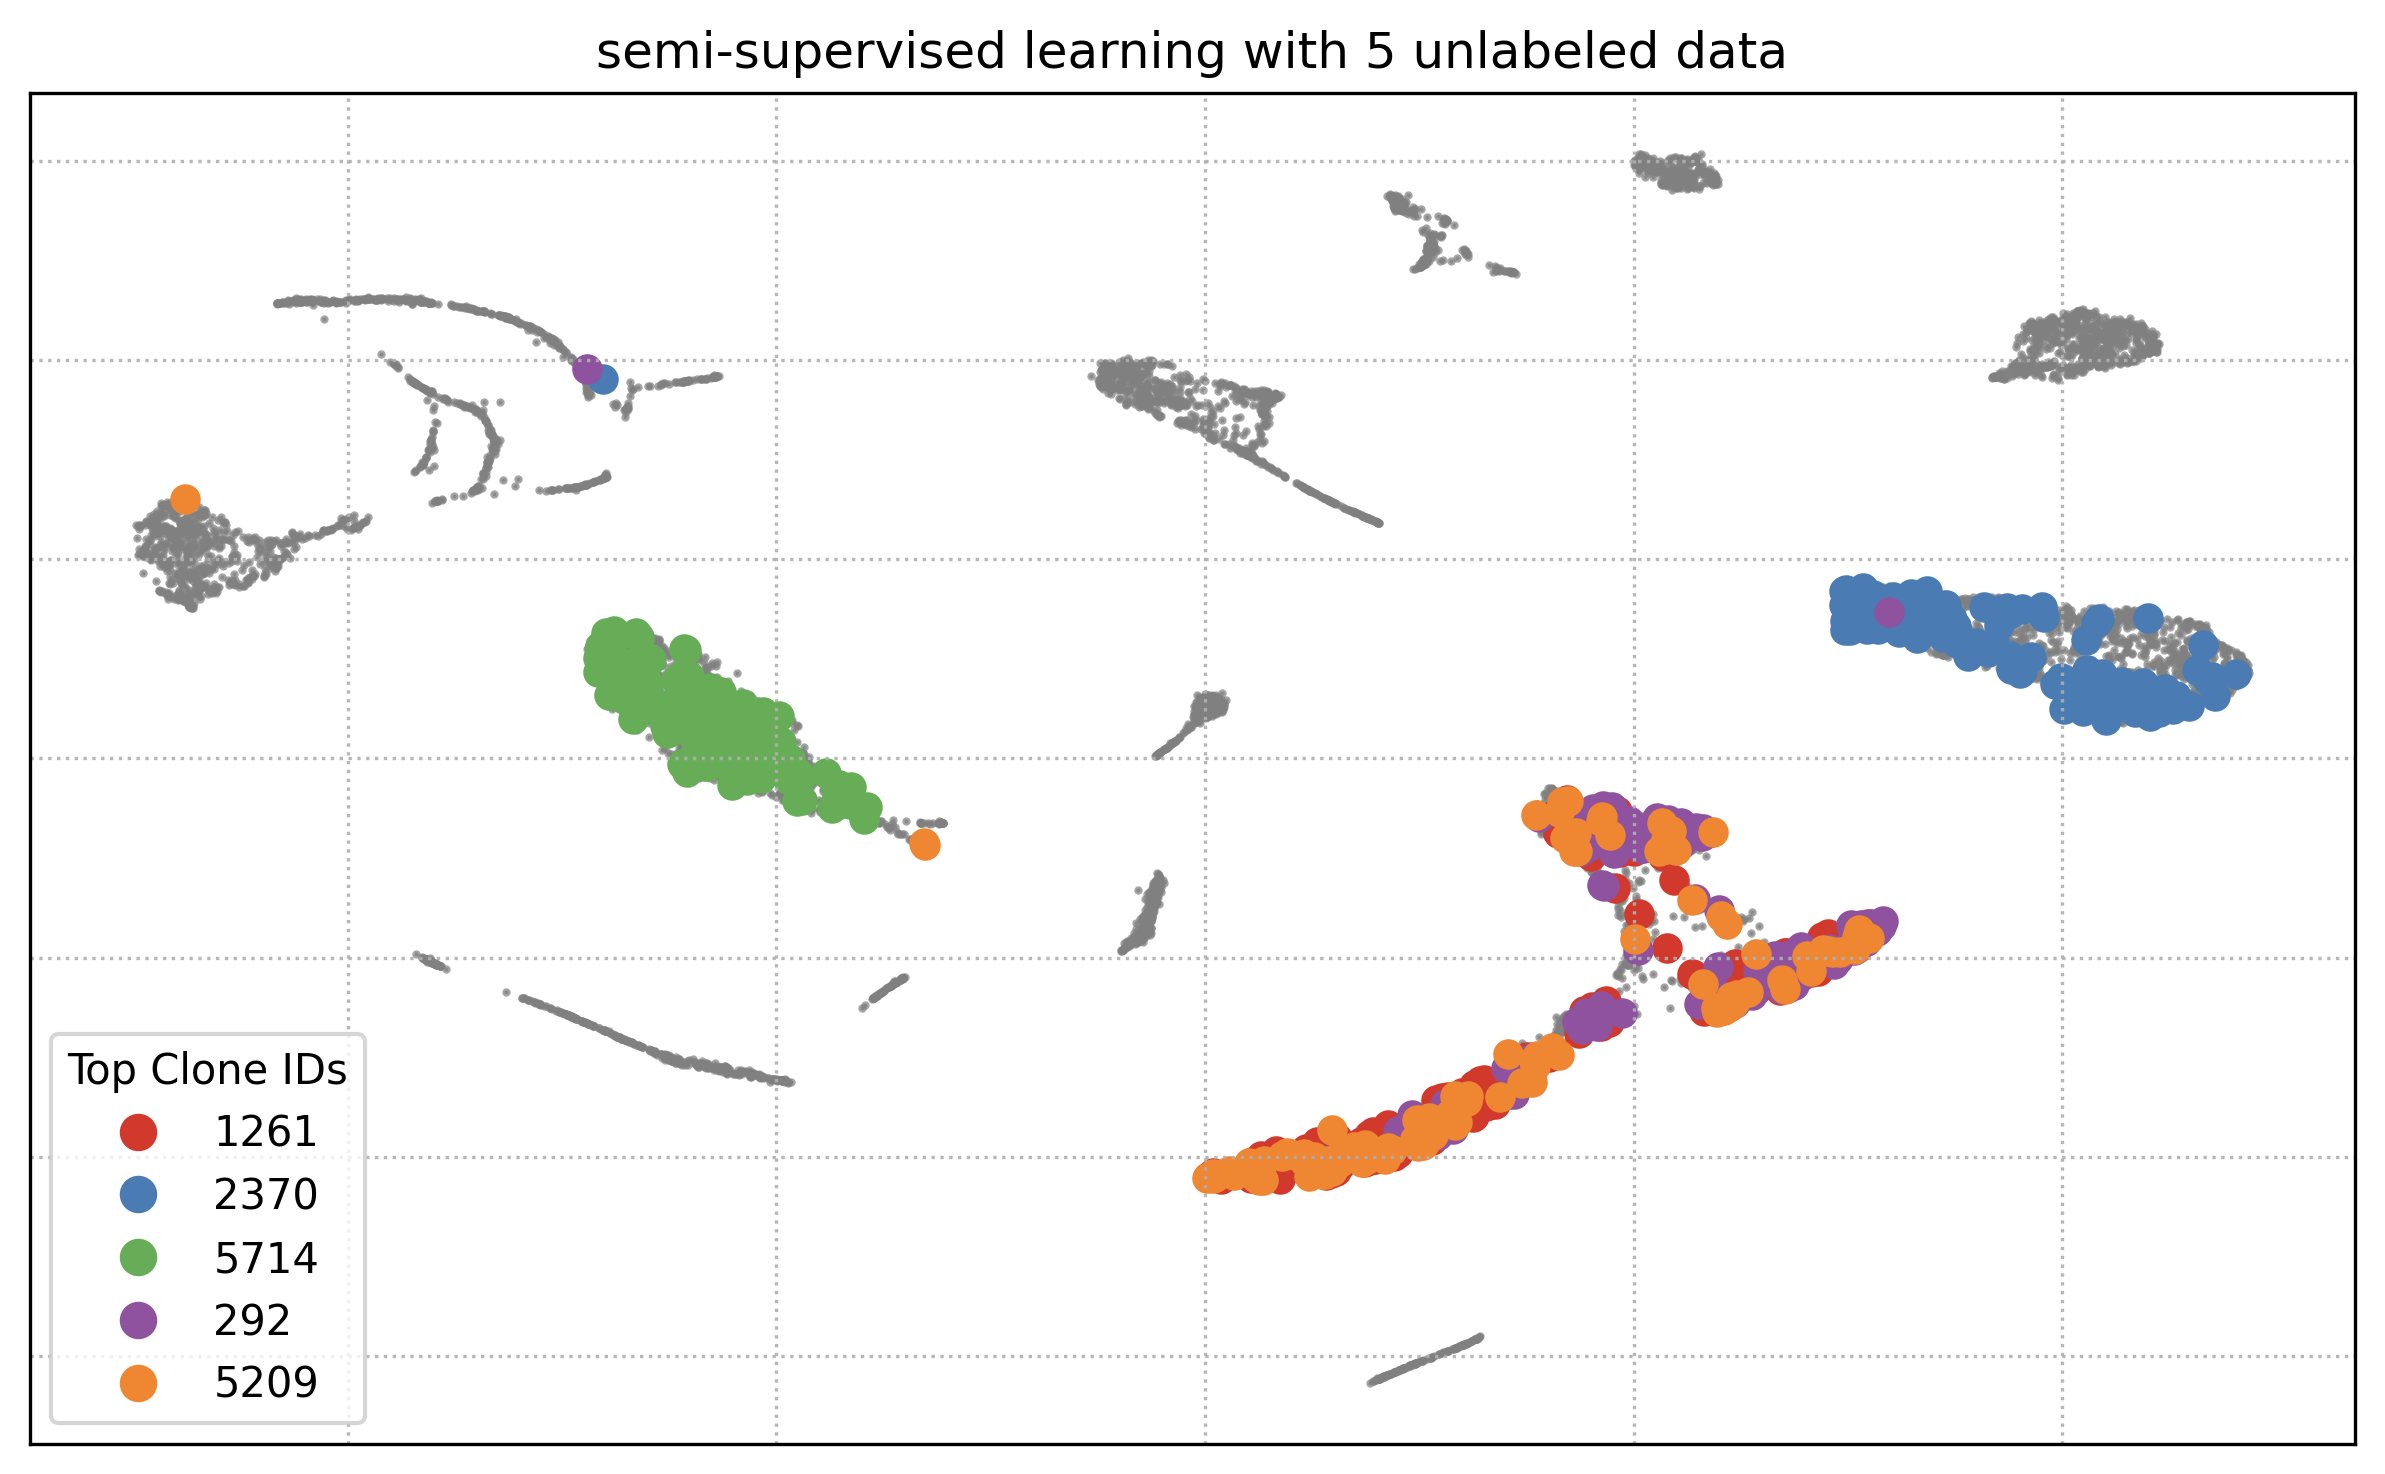

KNN classifier training accuracy: 14.83%
Calinski-Harabasz Score: 156.93630178743607


/opt/anaconda3/envs/scvi-env/lib/python3.9/site-packages/threadpoolctl.py:1010: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


In [16]:
eval_semi_train = LCL_eval.Eval(train_semi, adata_train)
eval_semi_train.plot_umap_top_lin("semi-supervised learning with 5 unlabeled data")
eval_semi_train.KNN_train()
score_10_train = eval_semi_train.calculate_calinski_harabasz_score()

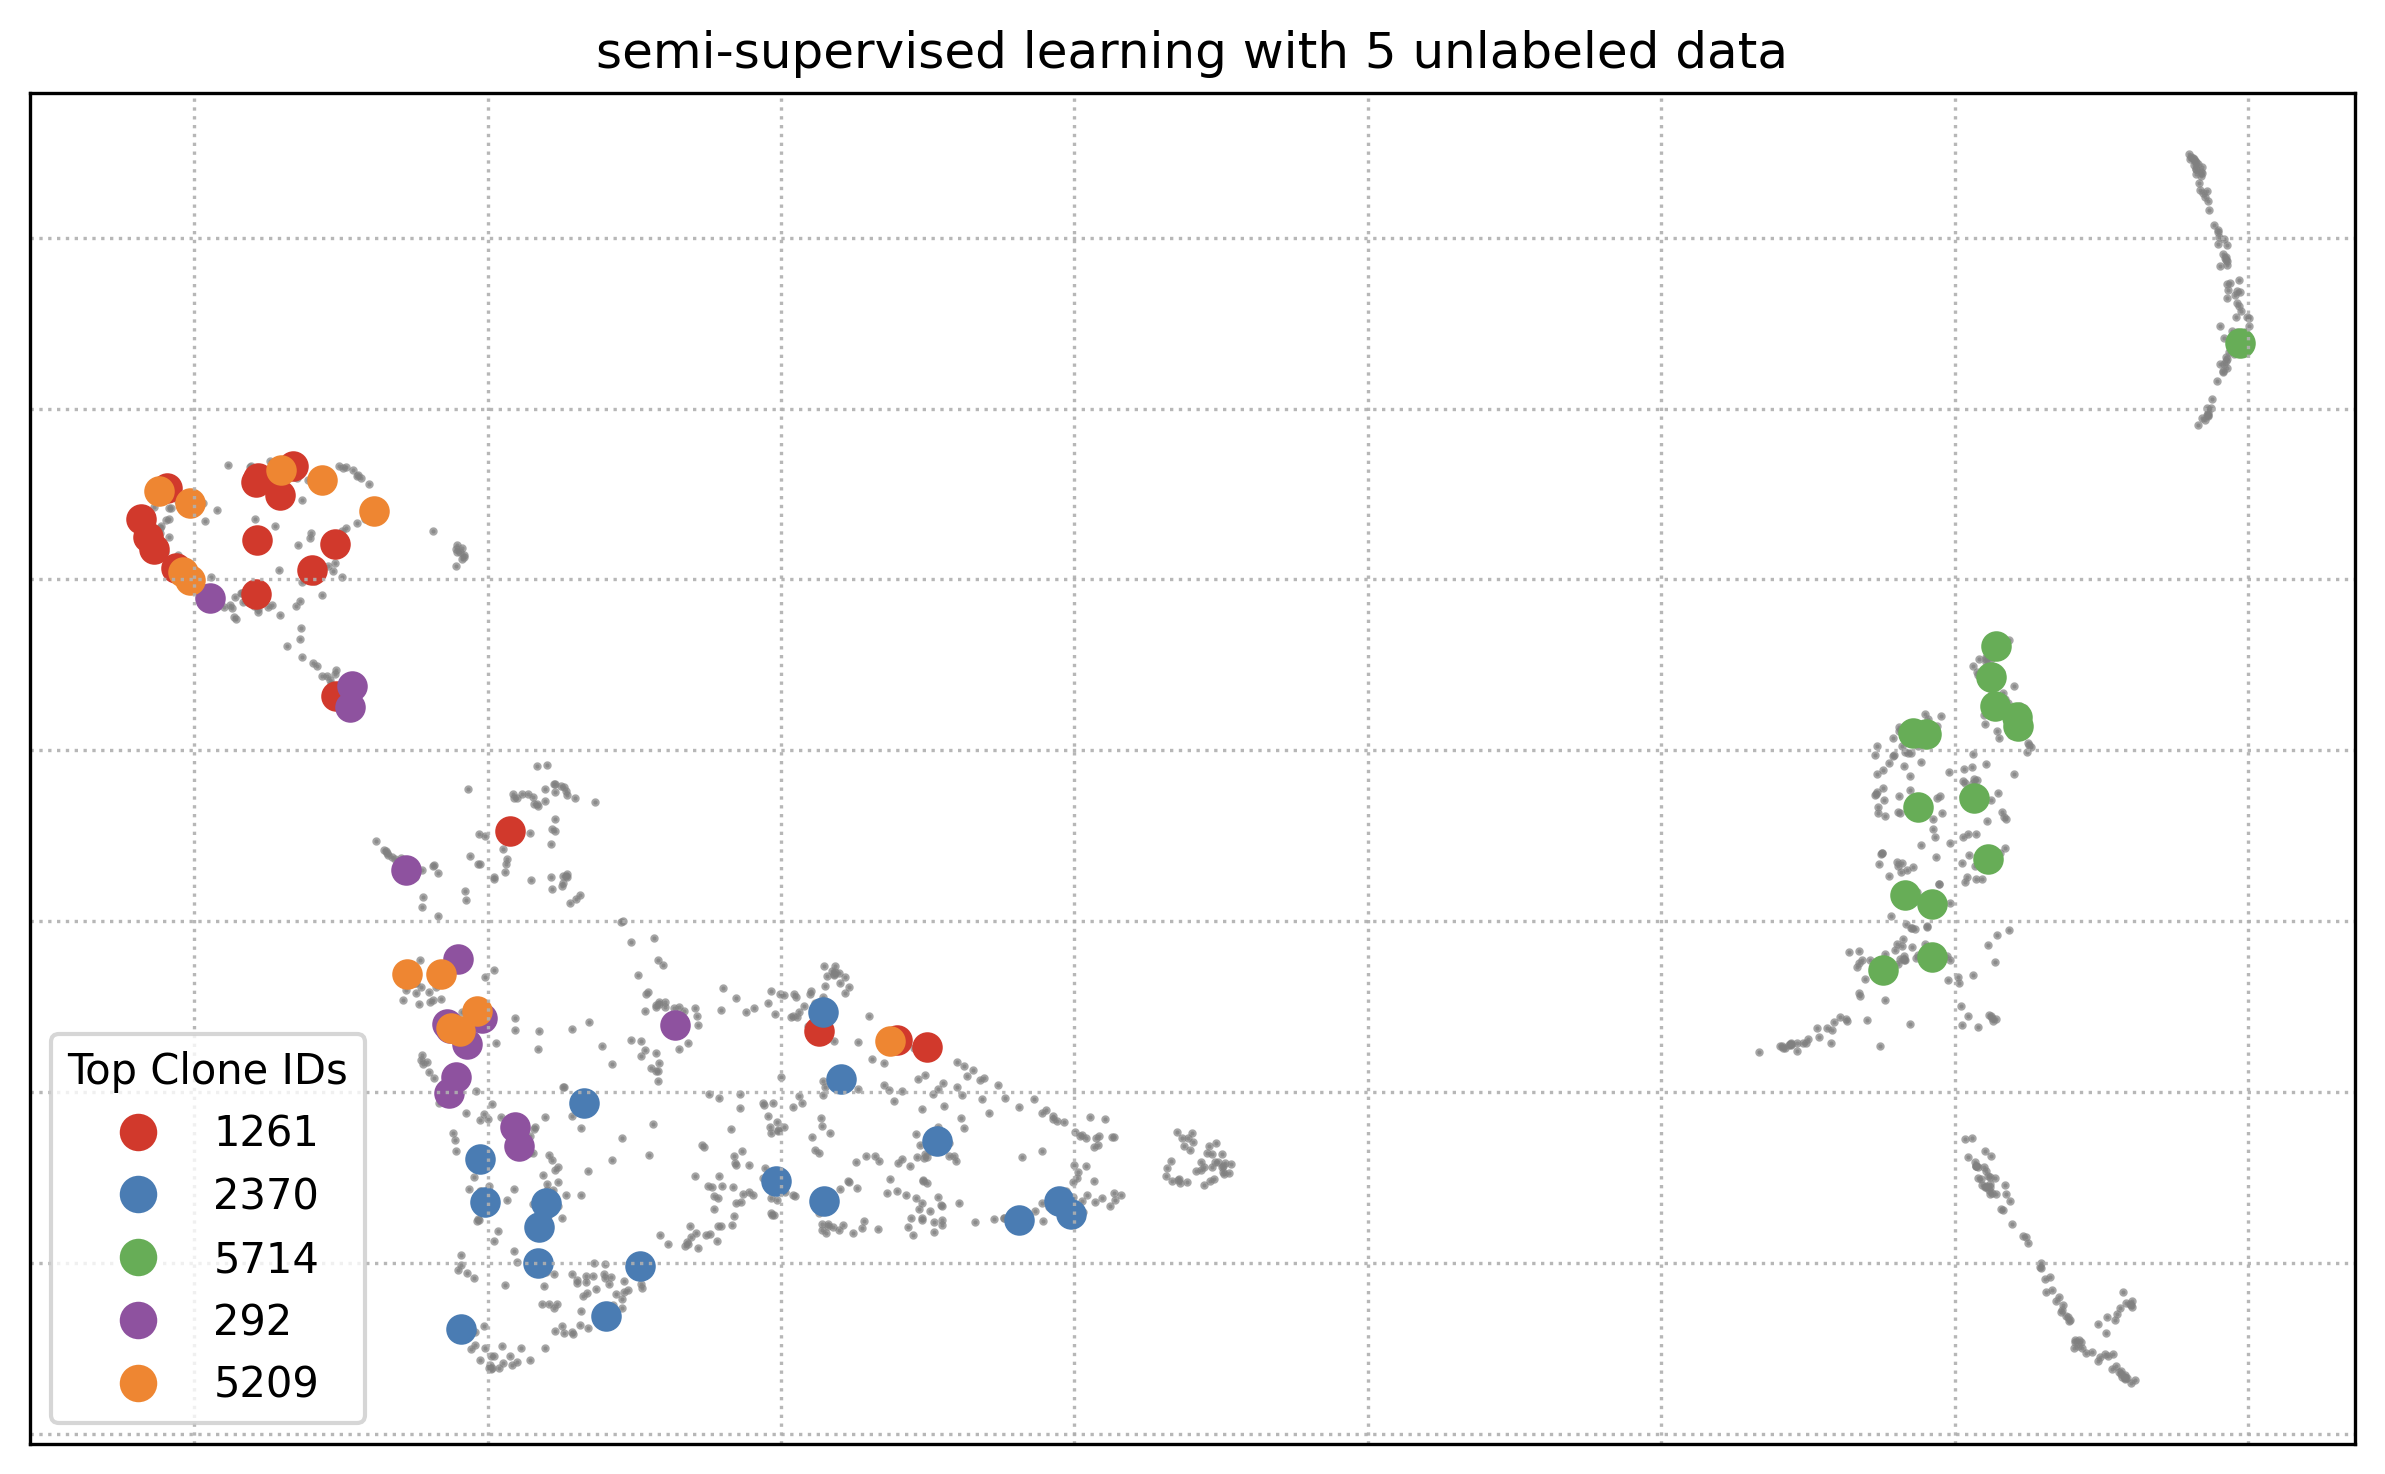

Calinski-Harabasz Score: 15.460659289337803
KNN classifier testing accuracy: 8.33%


0.08326530612244898

In [17]:
eval_semi_test = LCL_eval.Eval(test_semi, adata_test)
eval_semi_test.plot_umap_top_lin("semi-supervised learning with 5 unlabeled data")
score_semi_test = eval_semi_test.calculate_calinski_harabasz_score()
eval_semi_train.KNN_test(test_semi, adata_test)